# Final Notebook

* Group project of Alex FitzGerald, Mychal Dubyk, Anton Smirnov
* Student pace: full time
* Scheduled project review 6/3/2022 
* Instructors: William Wang, Daniel Burdeno 


# Performance by budget tier

## Package imports

In [1]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import zipfile

%matplotlib inline

### Data Imports
* movie gross and production budget in 'tn.movie_budgets.csv.gz'

In [2]:
df_movie_budget = pd.read_csv("zippedData/tn.movie_budgets.csv.gz")
df_movie_budget.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


### Prepare the data for analysis

In [3]:
#Convert production_budget to an integer
df_movie_budget.production_budget = df_movie_budget.production_budget.str.replace('$','').str.replace(',','')
df_movie_budget.production_budget = df_movie_budget.production_budget.astype(np.int64)

#Convert domestic_gross to an integer
df_movie_budget.domestic_gross = df_movie_budget.domestic_gross.str.replace('$','').str.replace(',','')
df_movie_budget.domestic_gross = df_movie_budget.domestic_gross.astype(np.int64)

#Convert worldwide_gross to an integer
df_movie_budget.worldwide_gross = df_movie_budget.worldwide_gross.str.replace('$','').str.replace(',','')
df_movie_budget.worldwide_gross = df_movie_budget.worldwide_gross.astype(np.int64)

In [4]:
#create a release year column
df_movie_budget["release_year"] = df_movie_budget["release_date"].str[-4:]
df_movie_budget.worldwide_gross = df_movie_budget.worldwide_gross.astype(int)

In [5]:
#Find the count of non-unique movie names
len(df_movie_budget)-len(df_movie_budget["movie"].unique())

84

In [6]:
#Create a more unique identifier for the film's name called title_and_year
df_movie_budget["title_and_year"] = df_movie_budget["movie"] + " (" + df_movie_budget["release_year"].astype(str)+")"

In [7]:
#Confirm that we have a more unique column of movie names in title_and_year
len(df_movie_budget)-len(df_movie_budget["title_and_year"].unique())

1

In [8]:
#Range of years in our data
df_movie_budget["release_year"].astype(int).max() - df_movie_budget["release_year"].astype(int).min() 

105

In [9]:
#We have some old movies in our data but the lare majority of the films were produced int he past 20 years
df_movie_budget["release_year"].astype(int).describe()

count    5782.000000
mean     2003.967139
std        12.724386
min      1915.000000
25%      2000.000000
50%      2007.000000
75%      2012.000000
max      2020.000000
Name: release_year, dtype: float64

In [10]:
#Add an ROI and profit column
df_movie_budget["profit"] = df_movie_budget["worldwide_gross"]-df_movie_budget["production_budget"]
df_movie_budget["ROI"] = df_movie_budget["profit"]/df_movie_budget["production_budget"]

#### Bucket budgets into tiers and remove irrelevant tiers

Screen Actors Guild project budgets https://www.sagaftra.org/production-center/contract/813/getting-started

In [11]:
#budget ranges from SAG
student_film = range(0,34999)
short_project = range(35000,49999)
ultra_low_budget = range(50000,299999)
moderate_low_budget = range(300000,699999)
low_budget_theatrical = range(700000,1999999)
threatrical_budget = range(2000000,150000000)
#blockbuster  150,000,000 and 400,000

In [12]:
#create a function that takes in a budget and returns the budget tier
def find_budget(x):
    if x in student_film:
        return("student_film")
    elif x in short_project:
        return("short_project")
    elif x in ultra_low_budget:
        return("ultra_low_budget")
    elif x in moderate_low_budget:
        return("moderate_low_budget")
    elif x in low_budget_theatrical:
        return("low_budget_theatrical")
    elif x in threatrical_budget:
        return("threatrical_budget")
    elif x >= 150000000:
        return("blockbuster")
    else:
        return("N/A")

In [13]:
#create a new column that includes the budget tier
df_movie_budget["budget_tier"] = df_movie_budget["production_budget"].map(find_budget)

In [14]:
#Remove scientific notation round up to the nearest integer
pd.options.display.float_format = '{:.0f}'.format
df_movie_budget.groupby('budget_tier').mean().sort_values("production_budget")

,id,production_budget,domestic_gross,worldwide_gross,profit,ROI
budget_tier,,,,,,
student_film,60,17104,1247342,1289271,1272167,63
short_project,32,39400,87020,97172,57772,2
ultra_low_budget,52,166012,1915045,3231987,3065974,22
moderate_low_budget,45,459071,4033616,6282674,5823603,12
low_budget_theatrical,50,1208675,5207438,8093388,6884713,6
threatrical_budget,51,30200583,40565626,83260216,53059633,2
blockbuster,49,189298462,225876251,591792958,402494496,2


In [15]:
#we will drop the student_film and short_project rows because Mircrosoft is not interested in such small investments despite their high ROI because the profit isn't worth their time
df_movie_budget_cleaned = df_movie_budget[df_movie_budget["budget_tier"].str.contains("student_film|short_project") == False]

#### Examine the tendancies of ROI data & adjust for risk
* Lower budget films have enormous standard deviation of their ROIs
* This standard devation can be thought of as risk, so lower budget films are riskier
* To control for for the risk of the investment, we will be creating a new column called adjusted_risk that used an adjusted Sharpe Ratio*

* *https://www.investopedia.com/terms/s/sharperatio.asp

In [16]:
#Investigate the data tendancies of gross 
df_movie_budget_cleaned.groupby('budget_tier')["worldwide_gross"].describe().sort_values("budget_tier")

,count,mean,std,min,25%,50%,75%,max
budget_tier,,,,,,,,
blockbuster,195,591792958,435848659,-2086758901,336080954,542537546,800205477,2053311220
low_budget_theatrical,395,8093388,24927738,0,12720,839145,5479640,268000000
moderate_low_budget,170,6282674,26032754,0,0,85016,2028547,248300000
threatrical_budget,4806,83260216,129092641,0,9206662,35579092,101082961,1341693157
ultra_low_budget,160,3231987,9975372,0,0,33262,2025695,99750000


In [17]:
#Lower budget films have enormous standard deviation of their ROIs
df_movie_budget_cleaned.groupby('budget_tier')["ROI"].describe().sort_values("budget_tier")

,count,mean,std,min,25%,50%,75%,max
budget_tier,,,,,,,,
blockbuster,195,2,2,-11,1,2,3,7
low_budget_theatrical,395,6,25,-1,-1,-0,4,311
moderate_low_budget,170,12,51,-1,-1,-1,4,431
threatrical_budget,4806,2,6,-1,-0,1,3,99
ultra_low_budget,160,22,68,-1,-1,-1,9,498


In [18]:
#Create a dictionary sharpe_ratio_adjuster to assit in adjusting our ROI column
ROI_std_values = list(df_movie_budget_cleaned.groupby('budget_tier').std().sort_values("production_budget")["ROI"].values)
ROI_std_keys = list(df_movie_budget_cleaned.groupby('budget_tier').std().sort_values("production_budget")["ROI"].index)
sharpe_ratio_adjuster = dict(zip(ROI_std_keys,ROI_std_values))
sharpe_ratio_adjuster

{'ultra_low_budget': 67.77891102442578,
 'moderate_low_budget': 51.36547115598832,
 'low_budget_theatrical': 25.20094233428327,
 'threatrical_budget': 5.538579427591486,
 'blockbuster': 2.0201318518742015}

In [19]:
#create a new column called adjusted_ROI
df_movie_budget_cleaned["adjusted_ROI"] = df_movie_budget_cleaned["ROI"] / df_movie_budget_cleaned["budget_tier"].map(sharpe_ratio_adjuster)

<ipython-input-19-52d23e069a46>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_movie_budget_cleaned["adjusted_ROI"] = df_movie_budget_cleaned["ROI"] / df_movie_budget_cleaned["budget_tier"].map(sharpe_ratio_adjuster)


#### Examine relationship between budget tier & profitability

* There is strong positive correlation between size of the budget tier and total profit of the film <br>
* There is a negative correlation between size of the budget tier and ROI of the film<br>
* However, when we look at the relationship between budget tier and Adjusted ROI, the correlation flips and it's clear that the highest budget tiers produce the largest risk Adjusted ROI.
* This suggests that when you want to make a lot of money from a single film and you want to avoid risk, the best strategy is to invest in a blockbuster. When you consider the demands of filling out a streaming service with content, it becomes neccesary to invest in other less expensive budget tiers. The best way to fill out the content library is with but given the flexibility to invest in multiple films, spreading your budget out to multiple less-expensive films is more profitable.

<ipython-input-20-48991e602106>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['${:,.0f}'.format(x) for x in current_values]);


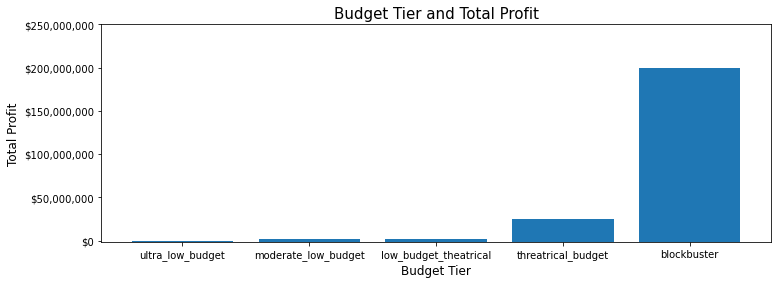

In [20]:
#Plotting profit by budget tier
y = df_movie_budget_cleaned.groupby('budget_tier').mean().sort_values("production_budget")["profit"]
x = list(df_movie_budget_cleaned.groupby('budget_tier').mean().sort_values("production_budget")["profit"].index)
fig, ax = plt.subplots(figsize=(12, 4))
ax.bar(x,y)
#remove scientific notation
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)
#change yaxes number format
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['${:,.0f}'.format(x) for x in current_values]);
#add chart and axes titles
ax.set_title("Budget Tier and Total Profit",fontsize=15)
ax.set_ylabel("Total Profit",fontsize=12)
ax.set_xlabel("Budget Tier",fontsize=12);
#adjust y axes ticks
plt.yticks(np.arange(min(y), 600000000, 100000000));

<ipython-input-21-7856b548c8d6>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values]);


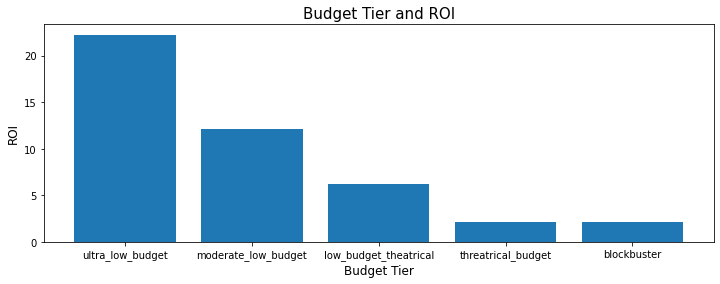

In [21]:
#Plotting ROI by budget tier
y = df_movie_budget_cleaned.groupby('budget_tier').mean().sort_values("production_budget")["ROI"]
x = list(df_movie_budget_cleaned.groupby('budget_tier').mean().sort_values("production_budget")["ROI"].index)
fig, ax = plt.subplots(figsize=(12, 4))
ax.bar(x,y)
#remove scientific notation
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)
#change yaxes number format
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values]);
#add chart and axes titles
ax.set_title("Budget Tier and ROI",fontsize=15)
ax.set_ylabel("ROI",fontsize=12)
ax.set_xlabel("Budget Tier",fontsize=12);
#adjust y axes ticks
plt.yticks(np.arange(0, max(y)+2, 5));

In [22]:
!ls

awesome.gif
CONTRIBUTING.md
final_notebook.ipynb
LICENSE.md
movie_data_erd.jpeg
README.md
student.ipynb
student-Copy1.ipynb
visualization_images
zippedData


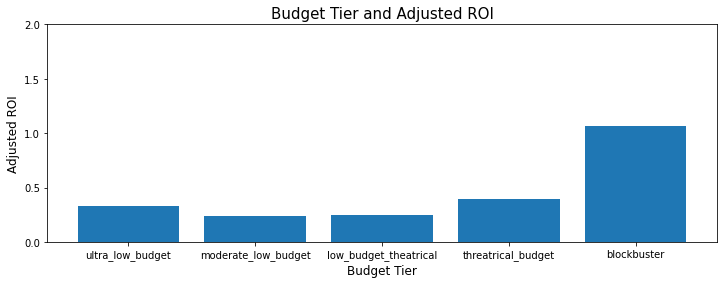

In [23]:
#Plotting adjusted ROI by budget tier
y = df_movie_budget_cleaned.groupby('budget_tier').mean().sort_values("production_budget")["adjusted_ROI"]
x = list(df_movie_budget_cleaned.groupby('budget_tier').mean().sort_values("production_budget")["adjusted_ROI"].index)
fig, ax = plt.subplots(figsize=(12, 4))
ax.bar(x,y)
#remove scientific notation
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)
#add chart and axes titles
ax.set_title("Budget Tier and Adjusted ROI",fontsize=15)
ax.set_ylabel("Adjusted ROI",fontsize=12)
ax.set_xlabel("Budget Tier",fontsize=12);
#adjust y axes ticks
plt.yticks(np.arange(0, max(y)+1, .5))
#save figure to visualization_images folder
plt.savefig("visualization_images/Budget_Tier_and_Adjusted_ROI");

### Budget allocation

#### Assumptions
* Assume a budget of 5B movie budget (Netflix spends 17B toatl, HBO spends 18B total)
https://www.indiewire.com/2022/03/streaming-wars-content-spend-disney-netflix-hbo-paramount-1234703867/

* Assume Microsoft needs to produce 100 new titles per year to keep up with Netflix's 153 new movie titles in 2021
https://en.wikipedia.org/wiki/List_of_Netflix_original_films_(2021)

In [24]:
budget_allocation_table = {'Budget_tier': ['Blockbuster', 'Theatrical_budget','Ultra_low_budget'],
                           'Films':  [25,10,65],
                           'Production_cost': [4732461550,302005830,10790780],
                           'Budget_allocation_%': [.938,.060,.002]}
pd.DataFrame(budget_allocation_table)

,Budget_tier,Films,Production_cost,Budget_allocation_%
0,Blockbuster,25,4732461550,1
1,Theatrical_budget,10,302005830,0
2,Ultra_low_budget,65,10790780,0


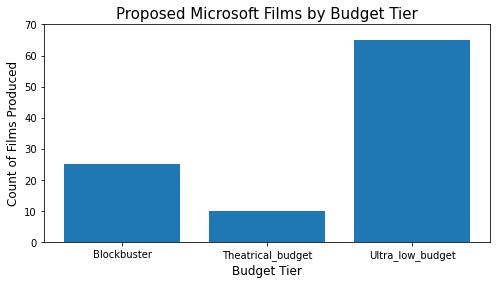

In [25]:
#Plotting proposed films production by budget tier

y = budget_allocation_table['Films']
x = budget_allocation_table['Budget_tier']

fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(x,y)

#add chart and axes titles
ax.set_title("Proposed Microsoft Films by Budget Tier",fontsize=15)
ax.set_ylabel("Count of Films Produced",fontsize=12)
ax.set_xlabel("Budget Tier",fontsize=12);
#adjust y axes ticks
plt.yticks(np.arange(0, 80, 10))
#save figure to visualization_images folder
plt.savefig("visualization_images/Proposed_Microsoft_Films_by_Budget_Tier");

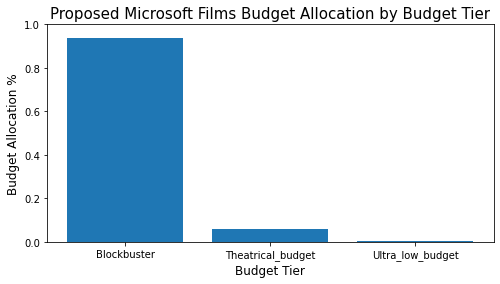

In [26]:
#Plotting proposed budget allocation by budget tier

y = budget_allocation_table['Budget_allocation_%']
x = budget_allocation_table['Budget_tier']

fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(x,y)
#remove scientific notation
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)

#add chart and axes titles
ax.set_title("Proposed Microsoft Films Budget Allocation by Budget Tier",fontsize=15)
ax.set_ylabel("Budget Allocation %",fontsize=12)
ax.set_xlabel("Budget Tier",fontsize=12);
#adjust y axes ticks
plt.yticks(np.arange(0, 1.1, .2))
#save figure to visualization_images folder
plt.savefig("visualization_images/Proposed_Microsoft_Films_Budget_Allocation_by_Budget_Tier");

### Recommendations
* Microsoft should allocate 94% of budget to Blockbusters because they generate the best risk adjusted ROI
* To fulfill the required 100 films, use .21% of the budget producing 65 Ultra Low Budget films. These have the benefit of being incredibly cheap and stand a chance of far outperfoming their budget
* The safe bet to fulfil the remaining 10 film requirement is to invest in Theatrical budget films which have a solid risk adjusted ROI and are less expensive than Blockbusters
Allocate (x) to moderate_low_budget and low_budget_theatrical because they produce high ROIm

# 

Next section is focused on further minimizing the risk of low return on investment in high budget films.







# Finding least risk prone genre

### Motivation
* High budget productions require large investments. Analysis is conducted to determine the least risk prone genre of movies with budget from 50 million dollars and above and below average rating. The goal of the analysis is to minimize the risk of low return on investment by choosing the genre that would perform well regardles of potentially low ratings. 

### Datasets
* IMDb Datasets movie_basics, movie_ratings, tn.movie_budgets.csv.gz

#### Importing the datasets

In [27]:
# Extract IMDb SQL .db file
with zipfile.ZipFile('./zippedData/im.db.zip') as zipObj:
    # Extract all contents of .zip file into current directory
    zipObj.extractall(path='./zippedData/')
    
# Create connection to IMDb DB
con = sqlite3.connect('./zippedData/im.db')


In [28]:
schema_df = pd.read_sql("""
        SELECT *
        FROM sqlite_master """, con)

In [29]:
# Understanding the structure of the database
schema_df

,type,name,tbl_name,rootpage,sql
0,table,movie_basics,movie_basics,2,"CREATE TABLE ""movie_basics"" (\n""movie_id"" TEXT..."
1,table,directors,directors,3,"CREATE TABLE ""directors"" (\n""movie_id"" TEXT,\n..."
2,table,known_for,known_for,4,"CREATE TABLE ""known_for"" (\n""person_id"" TEXT,\..."
3,table,movie_akas,movie_akas,5,"CREATE TABLE ""movie_akas"" (\n""movie_id"" TEXT,\..."
4,table,movie_ratings,movie_ratings,6,"CREATE TABLE ""movie_ratings"" (\n""movie_id"" TEX..."
5,table,persons,persons,7,"CREATE TABLE ""persons"" (\n""person_id"" TEXT,\n ..."
6,table,principals,principals,8,"CREATE TABLE ""principals"" (\n""movie_id"" TEXT,\..."
7,table,writers,writers,9,"CREATE TABLE ""writers"" (\n""movie_id"" TEXT,\n ..."


In [30]:
# Looking at movie_basics
pd.read_sql(""" 
            SELECT * 
            FROM movie_basics
            
            """, con).describe()

,start_year,runtime_minutes
count,146144,114405
mean,2015,86
std,3,166
min,2010,1
25%,2012,70
50%,2015,87
75%,2017,99
max,2115,51420


In [31]:
# Looking at movie_ratings
pd.read_sql(""" 
            SELECT *
            FROM movie_ratings
        
            """, con).describe()

,averagerating,numvotes
count,73856,73856
mean,6,3524
std,1,30294
min,1,5
25%,6,14
50%,6,49
75%,7,282
max,10,1841066


In [32]:
# pulling movie_budgets csv
df_budget = pd.read_csv("zippedData/tn.movie_budgets.csv.gz")
df_budget.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


#### Joining data
Inner joining movie_ratings and movie_basics in order to have access to ratings and genres in one table

In [33]:
df_combined = pd.read_sql(""" 
            SELECT *
            FROM movie_ratings
            JOIN movie_basics
            ON movie_basics.movie_id = movie_ratings.movie_id
            """, con)

In [34]:
# Checking missing values
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         73856 non-null  object 
 1   averagerating    73856 non-null  float64
 2   numvotes         73856 non-null  int64  
 3   movie_id         73856 non-null  object 
 4   primary_title    73856 non-null  object 
 5   original_title   73856 non-null  object 
 6   start_year       73856 non-null  int64  
 7   runtime_minutes  66236 non-null  float64
 8   genres           73052 non-null  object 
dtypes: float64(2), int64(2), object(5)
memory usage: 5.1+ MB


#### Data cleaning

In [35]:
# Dropping missing values in genres column
df_combined.dropna(subset = ['genres'], inplace = True)

In [36]:
df_combined.head()

,movie_id,averagerating,numvotes,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt10356526,8,31,tt10356526,Laiye Je Yaarian,Laiye Je Yaarian,2019,117,Romance
1,tt10384606,9,559,tt10384606,Borderless,Borderless,2019,87,Documentary
2,tt1042974,6,20,tt1042974,Just Inès,Just Inès,2010,90,Drama
3,tt1043726,4,50352,tt1043726,The Legend of Hercules,The Legend of Hercules,2014,99,"Action,Adventure,Fantasy"
4,tt1060240,6,21,tt1060240,Até Onde?,Até Onde?,2011,73,"Mystery,Thriller"


In [37]:
# replacing $ and , characters in production_budget column
df_budget.production_budget = df_budget.production_budget.str.replace('$','').str.replace(',','')

# casting to integer so we can filter based on production budget 
df_budget.production_budget = df_budget.production_budget.astype(int)
df_budget.head(2)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,425000000,"$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,"$241,063,875","$1,045,663,875"


In [38]:
# slicing out high budget films in order to focus our analysis on high budget productions
df_high_budget = df_budget[df_budget.production_budget > 50000000]

In [39]:
# There are 16 different movies with the same title but different release date
df_high_budget[df_high_budget.duplicated(subset = ['movie'], keep = False) == True].sort_values('movie')

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
297,98,"Aug 7, 2015",Fantastic Four,120000000,"$56,117,548","$167,849,187"
484,85,"Jul 8, 2005",Fantastic Four,87500000,"$154,696,080","$333,132,750"
140,41,"May 16, 2014",Godzilla,160000000,"$200,676,069","$529,076,069"
273,74,"May 19, 1998",Godzilla,125000000,"$136,314,294","$376,000,000"
383,84,"Jul 25, 2014",Hercules,100000000,"$72,688,614","$243,388,614"
707,8,"Jun 13, 1997",Hercules,70000000,"$99,112,101","$250,700,000"
650,51,"Apr 16, 1999",Life,75000000,"$64,062,587","$73,521,587"
965,66,"Mar 24, 2017",Life,58000000,"$30,234,022","$100,929,666"
38,39,"May 14, 2010",Robin Hood,210000000,"$105,487,148","$322,459,006"
408,9,"Nov 21, 2018",Robin Hood,99000000,"$30,824,628","$84,747,441"


In [40]:
# Discovering that there are about 4 thousand of non unique titles in df_combined
len(df_combined.primary_title) - len(df_combined.primary_title.unique())

3804

##### Upon further examination, it becomes clear that non-unique titles belong to the distinct movies produced in different years

In [41]:
#Creating column "title_year" in table df_combined: to use it to merge tables without unnecessary data loss
df_combined['title_year'] = df_combined.apply(lambda row: row.primary_title + " " + str(row.start_year), axis=1)

In [42]:
df_combined.head(2)

,movie_id,averagerating,numvotes,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,title_year
0,tt10356526,8,31,tt10356526,Laiye Je Yaarian,Laiye Je Yaarian,2019,117,Romance,Laiye Je Yaarian 2019
1,tt10384606,9,559,tt10384606,Borderless,Borderless,2019,87,Documentary,Borderless 2019


In [43]:
#Creating column "title_year" in table df_high_budget: to use it to merge tables without unnecessary data loss
df_high_budget['title_year'] = df_high_budget.apply(lambda row: row.movie + row.release_date[-5:], axis=1)

<ipython-input-43-9ceda84810bf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_high_budget['title_year'] = df_high_budget.apply(lambda row: row.movie + row.release_date[-5:], axis=1)


In [44]:
#cleaning columns not needed from analysis
df_combined.drop(columns=['movie_id', 'original_title', 'primary_title', 'runtime_minutes', 'start_year'], axis=1, inplace = True)

In [45]:
#cleaning columns not needed from analysis
df_high_budget.drop(columns=['id', 'release_date'], inplace = True)

C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [46]:
# Casting string type to title_year
df_combined.title_year = df_combined.title_year.astype(str)
df_high_budget.title_year = df_high_budget.title_year.astype(str)

C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\pandas\core\generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [47]:
#Merging Budget and Combined tables to have access to all the data in one table
df_newdata = pd.merge(df_combined, df_high_budget, how = 'inner', on='title_year')

In [48]:
df_newdata.head(2)

,averagerating,numvotes,genres,title_year,movie,production_budget,domestic_gross,worldwide_gross
0,4,50352,"Action,Adventure,Fantasy",The Legend of Hercules 2014,The Legend of Hercules,70000000,"$18,848,538","$58,953,319"
1,4,69199,"Comedy,Drama,Romance",Sex and the City 2 2010,Sex and the City 2,95000000,"$95,347,692","$294,680,778"


In [49]:
#Filtering movies with the rating lower than median of the dataset. The analysis is focused on 
# the performance of low rating films.
low_ranking = df_newdata[df_newdata['averagerating'] < df_newdata['averagerating'].median()]

In [50]:
#Eliminating films with low review count in order to focus on ratings substantiated by the review count.
low_ranking = low_ranking[low_ranking['numvotes'] > 1000]

In [51]:
# Finding unique genres identifiers
genres_list = list(low_ranking.genres.unique())
newlst = []
for i in genres_list:
    
    newlst.extend(i.split(','))
unique_genres = list(set(newlst))
unique_genres

['Drama',
 'Action',
 'Musical',
 'Sci-Fi',
 'Horror',
 'Mystery',
 'War',
 'Animation',
 'History',
 'Western',
 'Crime',
 'Music',
 'Family',
 'Fantasy',
 'Adventure',
 'Romance',
 'Sport',
 'Comedy',
 'Thriller']

In [52]:
#converting column genres into a list of genre identifiers
low_ranking['genres'] = low_ranking.apply(lambda row: row.genres.split(','), axis=1)

In [53]:
#Exploding column with multiple genre identifiers into rows with single genre identifiers
low_ranking = low_ranking.explode('genres')

In [54]:
low_ranking.count()

averagerating        516
numvotes             516
genres               516
title_year           516
movie                516
production_budget    516
domestic_gross       516
worldwide_gross      516
dtype: int64

In [55]:
#converting gross columns into integer datatype
low_ranking.domestic_gross = low_ranking.domestic_gross.str.replace('$','').str.replace(',','')
# replacing $ and , characters in production_budget column
low_ranking.worldwide_gross = low_ranking.worldwide_gross.str.replace('$','').str.replace(',','')

# casting to integer so we can filter based on production budget is 
low_ranking.domestic_gross = low_ranking.domestic_gross.astype(int)
low_ranking.worldwide_gross = low_ranking.worldwide_gross.astype(int)

In [56]:
#Sanity check
low_ranking.head(2)

,averagerating,numvotes,genres,title_year,movie,production_budget,domestic_gross,worldwide_gross
0,4,50352,Action,The Legend of Hercules 2014,The Legend of Hercules,70000000,18848538,58953319
0,4,50352,Adventure,The Legend of Hercules 2014,The Legend of Hercules,70000000,18848538,58953319


##### ROI is calculated by subtracting the beginning value from the current value and then dividing the number by the beginning value.
https://www.investopedia.com/terms/r/returnoninvestment.asp

In [57]:
low_ranking['roi'] = (low_ranking['worldwide_gross'] - low_ranking['production_budget'])/low_ranking['production_budget']

In [58]:
# Creating profit column
low_ranking['profit'] = (low_ranking['worldwide_gross'] - low_ranking['production_budget'])

### Analysis and visualization

#### Romance genre stands out with negative correlation between rating and worldwide gross as well as ROI, and profit metrics.

In [59]:
low_ranking[['numvotes','production_budget']].astype(float).corr()

,numvotes,production_budget
numvotes,1,0
production_budget,0,1


In [60]:
low_ranking[low_ranking.genres=='Romance'].head()

,averagerating,numvotes,genres,title_year,movie,production_budget,domestic_gross,worldwide_gross,roi,profit
1,4,69199,Romance,Sex and the City 2 2010,Sex and the City 2,95000000,95347692,294680778,2,199680778
4,6,77709,Romance,Eat Pray Love 2010,Eat Pray Love,60000000,80574010,206598789,2,146598789
129,5,52396,Romance,Zookeeper 2011,Zookeeper,80000000,80360866,170805525,1,90805525
146,5,81706,Romance,Fifty Shades Darker 2017,Fifty Shades Darker,55000000,114434010,381398492,6,326398492
154,6,113775,Romance,Hall Pass 2011,Hall Pass,68000000,45060734,87173475,0,19173475


#### Plotting correlation between Rating and performance metrics: Profit, Worldwide gross, ROI

''

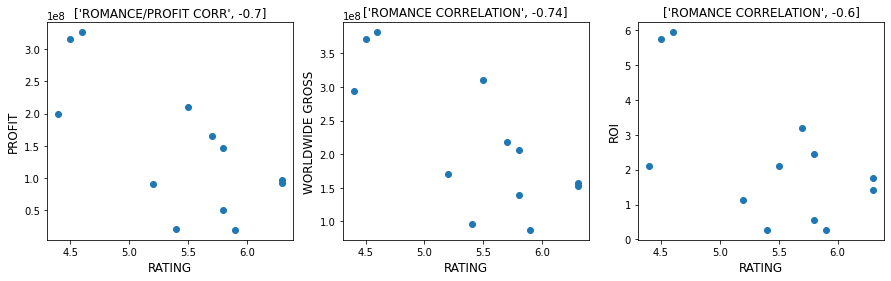

In [61]:
figure, (ax1, ax2, ax3) = plt.subplots(figsize=(15, 4), nrows=1, ncols=3)
scatter_plot_title = 'ROMANCE CORRELATION'
ax1.scatter(x= 'averagerating', y= 'profit', data = low_ranking[low_ranking['genres'] == 'Romance'])
ax1.set_title(["ROMANCE/PROFIT CORR", low_ranking[low_ranking.genres=='Romance'].corr().loc['profit'][0].round(2)], fontsize=12)
ax1.set_ylabel('PROFIT', fontsize=12)
ax1.set_xlabel('RATING', fontsize=12)



ax2.scatter(x= 'averagerating', y= 'worldwide_gross', data = low_ranking[low_ranking['genres'] == 'Romance'])
ax2.set_title([scatter_plot_title, low_ranking[low_ranking.genres=='Romance'].corr().loc['worldwide_gross'][0].round(2)], fontsize=12)
ax2.set_ylabel('WORLDWIDE GROSS', fontsize=12)
ax2.set_xlabel('RATING', fontsize=12)


ax3.scatter(x= 'averagerating', y= 'roi', data = low_ranking[low_ranking['genres'] == 'Romance'])
ax3.set_title([scatter_plot_title, low_ranking[low_ranking.genres=='Romance'].corr().loc['roi'][0].round(2)], fontsize=12)
ax3.set_ylabel('ROI', fontsize=12)
ax3.set_xlabel('RATING', fontsize=12)



;

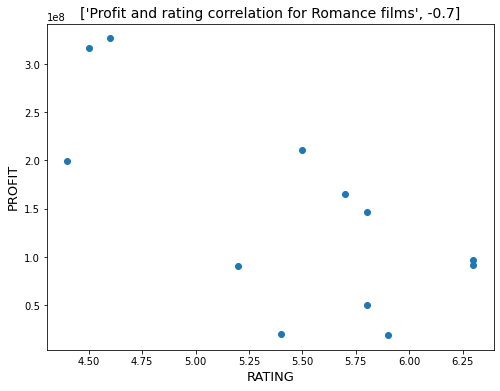

In [62]:
figure, ax1 = plt.subplots(figsize=(8, 6))
scatter_plot_title = 'Profit and rating correlation for Romance films'
ax1.scatter(x= 'averagerating', y= 'profit', data = low_ranking[low_ranking['genres'] == 'Romance'])
ax1.set_title([scatter_plot_title, low_ranking[low_ranking.genres=='Romance'].corr().loc['profit'][0].round(2)], fontsize=14)
ax1.set_ylabel('PROFIT', fontsize=13)
ax1.set_xlabel('RATING', fontsize=13)

# #calculate equation for trendline
# z, d = np.polyfit(low_ranking.averagerating, low_ranking.profit, 1)


# #add trendline to plot
# plt.plot(low_ranking.averagerating, z*(low_ranking.averagerating) + d)
plt.savefig("visualization_images/Profit and rating correlation");

### Conclusion
* High budget productions require large investments. The analysis is conducted to find the least risk prone genre of movies with budget from 50 million dollars and above in order to minimize risk of low return on investment. 
* Romance is the least risk prone genre. Poor quality of romance film, determined by its' low ratings, does not negatively affect the overal profit of the production. In fact, the analysis shows that poorly ranking romance films are likely to outperform movies with average ratings in the box office. It explains such an abundance of bad romance movies. 

### Recommendation
* It is advisable to invest in high budget romance films. Analysis shows that Romance is the least risk prone genre of films with budget 50 million and above. 